# Documento

In [521]:
# En el siguiente link se puede acceder al PDF que explica los objetivos del proyecto, analiza las variables y explica las conclusiones.

'https://drive.google.com/file/d/1228q9WOBENGAruCBQ8AVXtUdVS8odpgU/view?usp=sharing'

'https://drive.google.com/file/d/1228q9WOBENGAruCBQ8AVXtUdVS8odpgU/view?usp=sharing'

# Importación de librerías

In [522]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Seteo de estilo para gráficos

In [523]:
sns.set_style('whitegrid')
sns.set_palette('Paired')

# Funciones útiles

In [524]:
def limpiarOutliers(dataframe,columna):
  # Esta función no es mia.
  # Es una adaptación de una de un Colab de las clases
  df_output=dataframe.copy()
  z_score=(df_output[columna]-df_output[columna].mean())/df_output[columna].std()
  outliers_age_sup=z_score[z_score > 3].index
  outliers_age_inf=z_score[z_score < -3].index
  df_output=df_output.drop(outliers_age_sup)
  df_output=df_output.drop(outliers_age_inf)

  return df_output.reset_index(drop=True)


def reemplazarCaracter(dataset, columna, caracter, reemplazo):
  return dataset[columna].str.replace(caracter,reemplazo)

def eliminarColumnas(dataset, columnas):
  dfOutput = dataset.copy()

  for columna in columnas:
    dfOutput.drop(columns=columna, inplace=True)

  return dfOutput

def limpiarTodosLosOutliers(dataset, columna, cantidadDesvios=3):
  tercerQuartil = dataset[columna].quantile(0.75)
  desvioMaximo = dataset[columna].std() * cantidadDesvios
  valorMaximo = dataset[columna].max()

  while tercerQuartil + desvioMaximo < valorMaximo:
      dataset = limpiarOutliers(dataset,columna)
      tercerQuartil = dataset[columna].quantile(0.75)
      desvioMaximo = dataset[columna].std() * cantidadDesvios
      valorMaximo = dataset[columna].max()

  return dataset

def renombrarColumnas(dataset, buscado, reemplazo):
    renombradas = {}

    for columna in dataset.columns:
        if buscado in columna:
            renombradas[columna] = columna.replace(buscado, reemplazo)
        else:
            renombradas[columna] = columna

    return dataset.rename(columns=renombradas)

def graficarDistribucion(data,hue,titulo):
  fig,ax=plt.subplots(figsize=(8,8),nrows=2,ncols=1,sharex=True)
  sns.histplot(x=data,hue=hue,ax=ax[0],legend=False)
  sns.kdeplot(x=data,hue=hue,ax=ax[1],cumulative=False,fill=True,legend=False,clip=(data.min(),data.max()))
  plt.suptitle(titulo)
  ax[0].set_ylabel('Cantidad')
  ax[1].set_ylabel('Densidad')
  fig.legend(hue.unique(),title=hue.name.replace('_',' '))
  plt.tight_layout(rect=[0, 0, 1, 0.9])
  plt.gca().set(xlabel=None)
  plt.show()

def graficarCategorias(data,titulos,medidas):
  fig,ax=plt.subplots(figsize=(medidas[0],medidas[1]))
  sns.barplot(data.value_counts(),ax=ax)
  ax.set_title(titulos[0])
  ax.set_xlabel(titulos[1])
  ax.set_ylabel(titulos[2])
  plt.show()

def graficarProporciones(data,titulo,medidas):
  fig,ax=plt.subplots(figsize=(medidas[0],medidas[1]))
  ax.pie(data.value_counts(),autopct='%1.1f%%',pctdistance=0.8)
  ax.set_title(titulo)
  fig.legend(data.unique(),loc='center right',title=data.name.replace('_',' '))
  plt.show()

def graficarScatterplot(dataX,dataY,hue,titulos):
  fig,ax = plt.subplots(figsize=(12,5))
  sns.scatterplot(x=dataX,y=dataY,hue=hue,ax=ax,legend=True)
  ax.set_title(f'{titulos[0]} vs {titulos[1]}')
  ax.set_xlabel(titulos[0])
  ax.set_ylabel(titulos[1])
  plt.legend(title=hue.name.replace('_',' '))
  plt.show()

# Importación dataset

In [525]:
file = 'https://raw.githubusercontent.com/mgiongrande/DataScience2/refs/heads/main/CreditScore.csv'

data = pd.read_csv(file)

# Analizando información del dataset

In [526]:
data.shape

(12500, 28)

El dataset tiene 12.500 registros y 28 columnas

In [527]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        12500 non-null  object 
 1   Customer_ID               12500 non-null  object 
 2   Month                     12500 non-null  object 
 3   Name                      11271 non-null  object 
 4   Age                       12500 non-null  object 
 5   SSN                       12500 non-null  object 
 6   Occupation                12500 non-null  object 
 7   Annual_Income             12500 non-null  object 
 8   Monthly_Inhand_Salary     10584 non-null  float64
 9   Num_Bank_Accounts         12500 non-null  int64  
 10  Num_Credit_Card           12500 non-null  int64  
 11  Interest_Rate             12500 non-null  int64  
 12  Num_of_Loan               12500 non-null  object 
 13  Type_of_Loan              11074 non-null  object 
 14  Delay_

La mayoría de las columnas son tipo object, pero hay varias, como por ejemplo Age, Annual Income, Num of Loan, Num of Delayed Payment, Changed Credit Limit, Oustanding Debt, Amount Invested Monthly y Monthly Balance que parecieran ser numéricas por su nombre.

In [528]:
data.describe()

Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
count           1.058400e+04       12500.000000     12500.000000   
mean            3.971914e+05          16.939920        23.172720   
std             1.484950e+06         114.350815       132.005866   
min             3.036454e+02          -1.000000         0.000000   
25%             1.660393e+03           3.000000         4.000000   
50%             3.340643e+03           6.000000         5.000000   
75%             7.073469e+03           7.000000         7.000000   
max             1.138756e+07        1756.000000      1499.000000   

       Interest_Rate  Delay_from_due_date  Num_Credit_Inquiries  \
count   12500.000000         12500.000000          12243.000000   
mean       73.213360            21.060880             26.292330   
std       468.682227            14.863091            181.821031   
min         1.000000            -5.000000              0.000000   
25%         8.000000            10.000000              4.000000   
50%        14.000000            18.000000              6.000000   
75%        20.000000            28.000000             10.000000   
max      5789.000000            67.000000           2554.000000   

       Credit_Utilization_Ratio  Total_EMI_per_month  
count              12500.000000         12500.000000  
mean                  32.349265          1488.394291  
std                    5.156815          8561.449910  
min                   20.100770             0.000000  
25%                   28.066517            31.496968  
50%                   32.418953            72.887628  
75%                   36.623650           169.634826  
max                   48.199824         81971.000000

In [529]:
data.head(10)

ID Customer_ID   Month             Name  Age          SSN  \
0  0x1609   CUS_0xd40  August              NaN   23    #F%$D@*&8   
1  0x1615  CUS_0x21b1  August  Rick Rothackerj   28  004-07-5839   
2  0x1621  CUS_0x2dbc  August           Langep   34  486-85-3974   
3  0x162d  CUS_0xb891  August           Jasond   55  072-31-6145   
4  0x1639  CUS_0x1cdb  August           Deepaa   21  615-06-7821   
5  0x1645  CUS_0x95ee  August               Np   31  612-70-8987   
6  0x1651  CUS_0x284a  August           Nadiaq   34  411-51-0676   
7  0x165d  CUS_0x5407  August             Annk   30  500-92-6408   
8  0x1669  CUS_0x4157  August     Charlie Zhur  24_  070-19-1622   
9  0x1675  CUS_0xba08  August           Jamesj   45  366-68-1681   

      Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0      Scientist      19114.12           1.824843e+03                  3  ...   
1        Teacher      34847.84           3.037987e+03                  2  ...   
2       Engineer     143162.64           1.218722e+04                  1  ...   
3   Entrepreneur      30689.89           2.612491e+03                  2  ...   
4      Developer      35547.71           2.853309e+03                  7  ...   
5         Lawyer      73928.46           5.988705e+03                  4  ...   
6         Lawyer      131313.4           1.046921e+04                  0  ...   
7  Media_Manager      34081.38           2.611115e+06                  8  ...   
8         Doctor     114838.41           9.843868e+03                  2  ...   
9     Journalist       31370.8                    NaN                  1  ...   

   Credit_Mix  Outstanding_Debt Credit_Utilization_Ratio  \
0        Good            809.98                23.933795   
1        Good            605.03                32.933856   
2        Good           1303.01                38.374753   
3        Good            632.46                27.332515   
4    Standard            943.86                25.862922   
5        Good             548.2                31.580990   
6        Good            352.16                29.187913   
7           _           1704.18                33.823488   
8        Good           1377.74                27.813354   
9           _            421.43                37.565053   

       Credit_History_Age  Payment_of_Min_Amount Total_EMI_per_month  \
0                     NaN                     No           49.574949   
1   27 Years and 2 Months                     No           18.816215   
2   18 Years and 4 Months                     No          246.992319   
3  17 Years and 10 Months                     No           16.415452   
4   31 Years and 3 Months                    Yes            0.000000   
5   32 Years and 6 Months                     No            0.000000   
6   31 Years and 2 Months                     No          911.220179   
7   15 Years and 2 Months                    Yes           70.478333   
8  21 Years and 11 Months                     No          226.892792   
9   27 Years and 0 Months                     No           46.616129   

  Amount_invested_monthly                 Payment_Behaviour  \
0      24.785216509052056  High_spent_Medium_value_payments   
1      218.90434353388733    Low_spent_Small_value_payments   
2               __10000__   High_spent_Small_value_payments   
3      125.61725053231268   High_spent_Small_value_payments   
4      181.33090096186916   High_spent_Small_value_payments   
5       42.63559025189578                            !@9#%8   
6         870.52238171816   Low_spent_Medium_value_payments   
7       29.32636371091455  High_spent_Medium_value_payments   
8      254.57176724837916   High_spent_Large_value_payments   
9       252.6448271968889    Low_spent_Small_value_payments   

      Monthly_Balance Credit_Score  
0  358.12416760938714     Standard  
1  356.07810855965045         Good  
2    895.494583180492     Standard  
3  379.21638114119577     Standard  
4  364.00001570479753     Standar

In [530]:
#Consulto cuántos datos nulos hay para posteriormente imputarlos, eliminar la columna o eliminar los registros, según cada caso.

nulos = data.isnull().sum()

nulos[nulos > 0]

Name                       1229
Monthly_Inhand_Salary      1916
Type_of_Loan               1426
Num_of_Delayed_Payment      840
Num_Credit_Inquiries        257
Credit_History_Age         1120
Amount_invested_monthly     586
Monthly_Balance             147
dtype: int64

In [531]:
# Convierto a la columna ID en índice

data.set_index('ID',inplace=True)

# Trabajando con los datos

## Columna Age

In [532]:
# Primero verifico si hay edades con más de dos caracteres

data[data.Age.str.len() > 2]['Age'].count()

943

In [533]:
# Al hacer el head del dataset se encontraron edades con '_', ahora los voy a contar

data[data.Age.str.contains('_')]['Age'].count()

637

In [534]:
# Los reempleazo por caracter vacío

data.Age = reemplazarCaracter(data, 'Age','_','')

In [535]:
# Convierto la edad a entero

data.Age = data.Age.astype('int')

In [536]:
# Hago un describe para ver tengo valores que debo eliminar

data.Age.describe()

count    12500.000000
mean       105.771840
std        664.502705
min       -500.000000
25%         25.000000
50%         33.000000
75%         42.000000
max       8678.000000
Name: Age, dtype: float64

In [537]:
# Elimino aquellos con edad superior a 90 años y menores a 18

data.drop(data.loc[(data.Age > 90) | (data.Age < 18)].index, inplace=True)

## Columna Annual_Income

In [538]:
# Verifico cuántos valores tengo con '_'

data[data.Annual_Income.str.contains('_')]['Annual_Income'].count()

811

In [539]:
# Los reemplazo por 0

data.Annual_Income = reemplazarCaracter(data,'Annual_Income','_','')

In [540]:
# Convierto la columna a float

data.Annual_Income = data.Annual_Income.astype('float')

## Columna Num_of_Loan

In [541]:
# Verifico cuántos valores tengo con '_'

data[data.Num_of_Loan.str.contains('_')]['Num_of_Loan'].count()

578

In [542]:
# Lo reemplazo por un caracter vacío

data.Num_of_Loan = reemplazarCaracter(data, 'Num_of_Loan','_','')

In [543]:
# Convierto la columna a entero

data.Num_of_Loan = data.Num_of_Loan.astype('int')

## Columna Num_of_Delayed_Payment

In [544]:
# Como esta columna tiene valores nulos los filtro para poder contar los registros con '_'

d = data[~data.Num_of_Delayed_Payment.isnull()]

d[d.Num_of_Delayed_Payment.str.contains('_')]['Num_of_Delayed_Payment'].count()

323

In [545]:
# Reemplazo por vacío

data.Num_of_Delayed_Payment = reemplazarCaracter(data,'Num_of_Delayed_Payment','_','')

In [546]:
# Lo convierto a float para mantener los valores nulos e imputarlos postariormente

data.Num_of_Delayed_Payment = data.Num_of_Delayed_Payment.astype('float')

## Columna Changed_Credit_Limit

In [547]:
# Cuento la cantidad de registros con '_'

data[data.Changed_Credit_Limit.str.contains('_')]['Changed_Credit_Limit'].count()

236

In [548]:
# Los cambio a 0

data.Changed_Credit_Limit = reemplazarCaracter(data,'Changed_Credit_Limit','_','0')

In [549]:
# Modifico el tipo de dato de la columna

data.Changed_Credit_Limit = data.Changed_Credit_Limit.astype('float')

## Columna Num_Credit_Inquiries

In [550]:
# Modifico el tipo de datos, luego imputaré los valores faltantes

data.Num_Credit_Inquiries = data.Num_Credit_Inquiries.astype('float')

## Columna Num_Bank_Accounts

In [551]:
data.Num_Bank_Accounts.describe()

count    11512.000000
mean        16.850330
std        114.707968
min         -1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max       1756.000000
Name: Num_Bank_Accounts, dtype: float64

In [552]:
#Elimino los registros con valores menores 0 o mayores a 20

data.drop(data.loc[(data['Num_Bank_Accounts'] < 0) | (data['Num_Bank_Accounts'] > 20)].index, inplace=True)

## Columna Interest_Rate

In [553]:
data.Interest_Rate.describe()

count    11356.000000
mean        73.228602
std        471.944625
min          1.000000
25%          7.000000
50%         13.000000
75%         20.000000
max       5789.000000
Name: Interest_Rate, dtype: float64

In [554]:
# Elimino los valores mayores a 100. Al ser montos en dólares las tasas de interés tienen valores muchos más bajas en su moneda local a diferencia de países como el nuestro.

data.drop(data[data.Interest_Rate > 100].index,inplace=True)

## Columna Outstanding_Debt

In [555]:
# Cuento los registros con valores '_'

data.Outstanding_Debt = reemplazarCaracter(data, 'Outstanding_Debt','_','')

In [556]:
# Convierto la columna a float

data.Outstanding_Debt = data.Outstanding_Debt.astype('float')

## Columna Payment_of_Min_Amount

In [557]:
data.Payment_of_Min_Amount.value_counts()

Payment_of_Min_Amount
Yes    5621
No     4223
NM     1271
Name: count, dtype: int64

In [558]:
# Reemplazo la 'M' por 'o'

data.Payment_of_Min_Amount = reemplazarCaracter(data,'Payment_of_Min_Amount','M','o')

## Columna Amount_invested_monthly

In [559]:
# Cuento la cantidad de registros con '_'

d = data[~data.Amount_invested_monthly.isnull()]

d[d.Amount_invested_monthly.str.contains('_')]['Amount_invested_monthly'].count()

476

In [560]:
# Los reemplazo por vacío

data.Amount_invested_monthly = reemplazarCaracter(data, 'Amount_invested_monthly','_','')

In [561]:
# Convierto el tipo de dato a float

data.Amount_invested_monthly = data.Amount_invested_monthly.astype('float')

## Columna Payment_Behaviour

In [562]:
# Cuento las categorías

data.Payment_Behaviour.value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      2832
High_spent_Medium_value_payments    1980
High_spent_Large_value_payments     1528
Low_spent_Medium_value_payments     1496
High_spent_Small_value_payments     1239
Low_spent_Large_value_payments      1163
!@9#%8                               877
Name: count, dtype: int64

In [563]:
# Elimino los valores '!@9#%8'

data.drop(data[data.Payment_Behaviour == '!@9#%8'].index,inplace=True)

In [564]:
# Reemplazo los '_' por espacios

data.Payment_Behaviour = reemplazarCaracter(data,'Payment_Behaviour','_',' ')

## Columna Occupation

In [565]:
# Cuento las categorías

data.Occupation.value_counts()

Occupation
_______          707
Lawyer           677
Engineer         665
Accountant       660
Architect        660
Scientist        644
Entrepreneur     642
Journalist       642
Media_Manager    633
Mechanic         633
Teacher          628
Developer        622
Doctor           621
Musician         607
Writer           600
Manager          597
Name: count, dtype: int64

In [566]:
# Elimino los registros con categoría '___'

data.drop(data[data.Occupation.str.contains('__')].index,inplace=True)

In [567]:
# Convierto a los Media_Manager en Manager

data.Occupation = reemplazarCaracter(data,'Occupation','_',' ')

## Columna Type_of_Loan

In [568]:
# Consulto las categorías disponibles

data.Type_of_Loan.value_counts()

Type_of_Loan
Not Specified                                                                                                          142
Credit-Builder Loan                                                                                                    134
Payday Loan                                                                                                            131
Personal Loan                                                                                                          129
Student Loan                                                                                                           125
                                                                                                                      ... 
Personal Loan, Mortgage Loan, Not Specified, Auto Loan, Debt Consolidation Loan, Credit-Builder Loan, and Auto Loan      1
Auto Loan, Mortgage Loan, Auto Loan, Auto Loan, and Mortgage Loan                                                        1
Payday Loan, Payday Loan, Student Loan, and Payday Loan                                                                  1
Not Specified, Personal Loan, Student Loan, Personal Loan, Student Loan, and Payday Loan                                 1
Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan                                                  1
Name: count, Length: 4837, dtype: int64

Esta columna no la voy a utilizar, la eliminaré en el paso correspondiente.

## Columna Credit_Mix

In [569]:
data.Credit_Mix.value_counts()

Credit_Mix
Standard    3388
Good        2438
_           1985
Bad         1720
Name: count, dtype: int64

Faltan muchos valores en esta columna como para eliminarlos, por lo tanto esta columna la eliminaré.

## Columna Total_EMI_por_month

In [570]:
# Al hacer el describe al principio se encuentran muchos valores en 0, los voy a dejar nulos para imputarlos posteriormente

data.Total_EMI_per_month = data.Total_EMI_per_month.apply(lambda x: np.nan if x == 0 else x)

## Columna Credit_History_Age

In [571]:
data.Credit_History_Age.value_counts()

Credit_History_Age
20 Years and 0 Months    57
18 Years and 4 Months    57
19 Years and 9 Months    56
18 Years and 5 Months    56
16 Years and 2 Months    55
                         ..
1 Years and 0 Months      4
4 Years and 3 Months      4
4 Years and 10 Months     4
4 Years and 4 Months      3
0 Years and 8 Months      2
Name: count, Length: 331, dtype: int64

In [572]:
# Con la siguiente función voy a extraer los años y los meses para luego llenar una columna nueva con dichos valores
# Los meses los dividiré por 12 para obtener un número decimal.

def getCreditHistoryAge(data):
    patron = r'(?P<Anios>\d+)\s\w+\s\w+\s(?P<Meses>\d+)'
    regex = re.compile(patron)

    if isinstance(data, str):
        resultado = regex.search(data)
        try:
            output = float(resultado.group('Anios')) + float(resultado.group('Meses')) / 12
        except:
            output = np.nan
    else:
        output = np.nan

    return output

In [573]:
data['Credit_History'] = data['Credit_History_Age'].apply(getCreditHistoryAge)

## Columna Monthly_Balance

In [574]:
# Para convertir esta columna voy a utilizar otro método

data['Month_Balance'] = pd.to_numeric(data.Monthly_Balance, errors='coerce')

# Analizando nuevamente el dataset

In [575]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9531 entries, 0x1609 to 0x25fe1
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               9531 non-null   object 
 1   Month                     9531 non-null   object 
 2   Name                      8589 non-null   object 
 3   Age                       9531 non-null   int64  
 4   SSN                       9531 non-null   object 
 5   Occupation                9531 non-null   object 
 6   Annual_Income             9531 non-null   float64
 7   Monthly_Inhand_Salary     8088 non-null   float64
 8   Num_Bank_Accounts         9531 non-null   int64  
 9   Num_Credit_Card           9531 non-null   int64  
 10  Interest_Rate             9531 non-null   int64  
 11  Num_of_Loan               9531 non-null   int64  
 12  Type_of_Loan              8406 non-null   object 
 13  Delay_from_due_date       9531 non-null   int64  
 14  Num_o

In [576]:
# Elimino las columnas con las que no voy a trabajar

columnasAEliminar = ['Name','Monthly_Inhand_Salary','Type_of_Loan','Num_Credit_Card','Customer_ID','SSN','Month','Credit_History_Age','Monthly_Balance','Credit_Mix']

data2 = eliminarColumnas(data,columnasAEliminar)

In [577]:
# Consulto nuevamente el dataset

data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9531 entries, 0x1609 to 0x25fe1
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9531 non-null   int64  
 1   Occupation                9531 non-null   object 
 2   Annual_Income             9531 non-null   float64
 3   Num_Bank_Accounts         9531 non-null   int64  
 4   Interest_Rate             9531 non-null   int64  
 5   Num_of_Loan               9531 non-null   int64  
 6   Delay_from_due_date       9531 non-null   int64  
 7   Num_of_Delayed_Payment    8907 non-null   float64
 8   Changed_Credit_Limit      9531 non-null   float64
 9   Num_Credit_Inquiries      9332 non-null   float64
 10  Outstanding_Debt          9531 non-null   float64
 11  Credit_Utilization_Ratio  9531 non-null   float64
 12  Payment_of_Min_Amount     9531 non-null   object 
 13  Total_EMI_per_month       8522 non-null   float64
 14  Amoun

# Trabajando con outliers

Antes de imputar los valores nulos voy a ver si hay outliers a eliminar para no imputar valores utilizando valores que distorsionen las distribuciones.

## Columna Num_Credit_Inquiries

<Axes: ylabel='Num_Credit_Inquiries'>

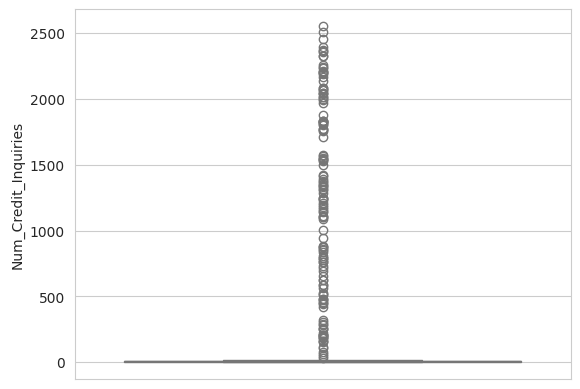

In [578]:
sns.boxplot(data2.Num_Credit_Inquiries)

In [579]:
data3 = limpiarTodosLosOutliers(data2,'Num_Credit_Inquiries')

In [580]:
sns.boxplot(data3.Num_Credit_Inquiries)

<Axes: ylabel='Num_Credit_Inquiries'>

## Columna Num_of_Loan

<Axes: ylabel='Num_of_Loan'>

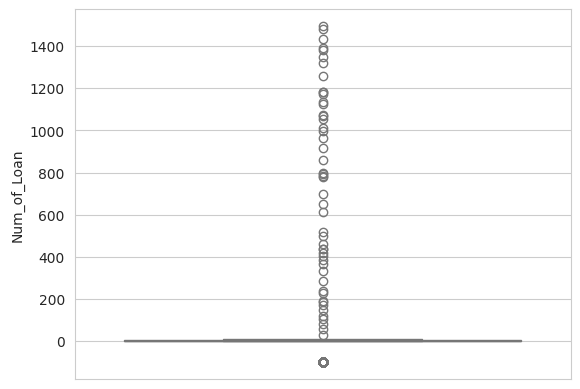

In [581]:
sns.boxplot(data3.Num_of_Loan)

In [582]:
data4 = limpiarTodosLosOutliers(data3, 'Num_of_Loan')

<Axes: ylabel='Num_of_Loan'>

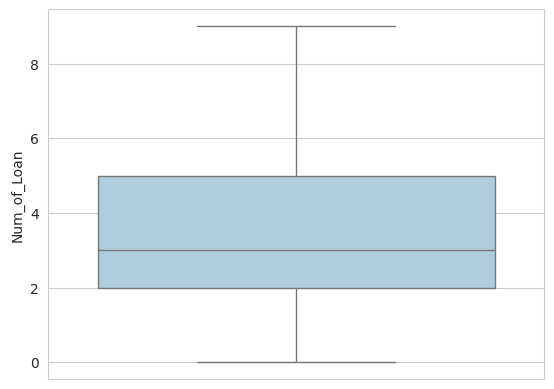

In [583]:
sns.boxplot(data4.Num_of_Loan)

## Columna Amount_invested_monthly

<Axes: ylabel='Amount_invested_monthly'>

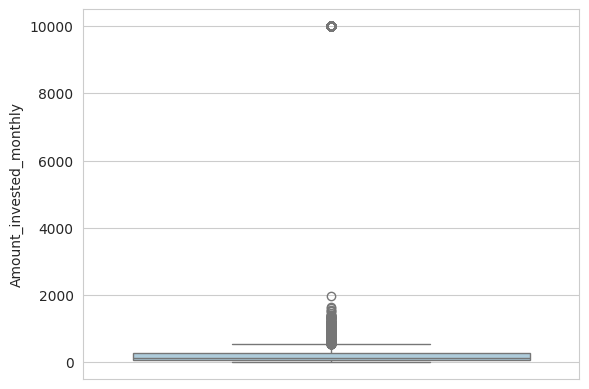

In [584]:
sns.boxplot(data4.Amount_invested_monthly)

In [585]:
data5 = limpiarTodosLosOutliers(data4,'Amount_invested_monthly')

<Axes: ylabel='Amount_invested_monthly'>

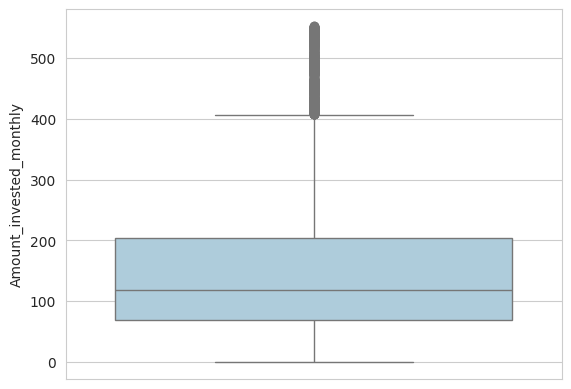

In [586]:
sns.boxplot(data5.Amount_invested_monthly)

## Columna Total_EMI_per_month

<Axes: ylabel='Total_EMI_per_month'>

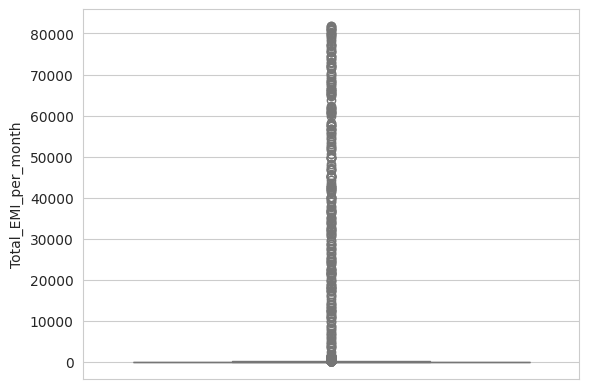

In [587]:
sns.boxplot(data5.Total_EMI_per_month)

In [588]:
data6 = limpiarTodosLosOutliers(data5,'Total_EMI_per_month')

<Axes: ylabel='Amount_invested_monthly'>

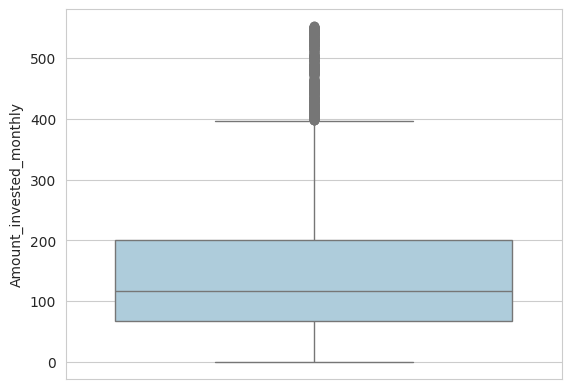

In [589]:
sns.boxplot(data6.Amount_invested_monthly)

## Columna Interest_Rate

In [590]:
sns.boxplot(data6.Interest_Rate)

<Axes: ylabel='Interest_Rate'>

In [591]:
data7 = limpiarTodosLosOutliers(data6, 'Interest_Rate')

In [592]:
sns.boxplot(data7.Interest_Rate)

<Axes: ylabel='Interest_Rate'>

## Columna Annual_Income

In [593]:
sns.boxplot(data7.Annual_Income)

<Axes: ylabel='Annual_Income'>

In [594]:
data8 = limpiarTodosLosOutliers(data7, 'Annual_Income')

In [595]:
sns.boxplot(data8.Annual_Income)

<Axes: ylabel='Annual_Income'>

In [596]:
data8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6677 entries, 0 to 6676
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       6677 non-null   int64  
 1   Occupation                6677 non-null   object 
 2   Annual_Income             6677 non-null   float64
 3   Num_Bank_Accounts         6677 non-null   int64  
 4   Interest_Rate             6677 non-null   int64  
 5   Num_of_Loan               6677 non-null   int64  
 6   Delay_from_due_date       6677 non-null   int64  
 7   Num_of_Delayed_Payment    6234 non-null   float64
 8   Changed_Credit_Limit      6677 non-null   float64
 9   Num_Credit_Inquiries      6544 non-null   float64
 10  Outstanding_Debt          6677 non-null   float64
 11  Credit_Utilization_Ratio  6677 non-null   float64
 12  Payment_of_Min_Amount     6677 non-null   object 
 13  Total_EMI_per_month       5933 non-null   float64
 14  Amount_i

# Imputación valores nulos

In [597]:
# Verifico las columnas con valores nulos

nulos = data8.isnull().sum()
nulos[nulos > 0]

Num_of_Delayed_Payment     443
Num_Credit_Inquiries       133
Total_EMI_per_month        744
Amount_invested_monthly    321
Credit_History             613
Month_Balance               14
dtype: int64

In [598]:
# Genero un dataframe con las columnas a imputar

data_imputable = data8[['Num_Credit_Inquiries','Credit_History','Amount_invested_monthly','Num_of_Delayed_Payment','Month_Balance','Total_EMI_per_month']]

In [599]:
# Importo e instancio la librería KNNImputer

from sklearn.impute import KNNImputer
imputer = KNNImputer()
data_imputada = imputer.fit_transform(data_imputable)

In [600]:
# Genero un dataframe con las columnas a imputar y las imputadas

df_imputado = pd.DataFrame(columns=data_imputable.columns, data=data_imputada,index=data_imputable.index)


In [601]:
# Genero el dataset final

data_prefinal = pd.merge(data8,df_imputado,left_index=True,right_index=True)

In [602]:
# Consulto el dataset

data_prefinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6677 entries, 0 to 6676
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6677 non-null   int64  
 1   Occupation                 6677 non-null   object 
 2   Annual_Income              6677 non-null   float64
 3   Num_Bank_Accounts          6677 non-null   int64  
 4   Interest_Rate              6677 non-null   int64  
 5   Num_of_Loan                6677 non-null   int64  
 6   Delay_from_due_date        6677 non-null   int64  
 7   Num_of_Delayed_Payment_x   6234 non-null   float64
 8   Changed_Credit_Limit       6677 non-null   float64
 9   Num_Credit_Inquiries_x     6544 non-null   float64
 10  Outstanding_Debt           6677 non-null   float64
 11  Credit_Utilization_Ratio   6677 non-null   float64
 12  Payment_of_Min_Amount      6677 non-null   object 
 13  Total_EMI_per_month_x      5933 non-null   float

In [603]:
# Elimino las columnas que fueron reemplazadas por las imputadas

data_prefinal.drop(columns=['Num_of_Delayed_Payment_x','Num_Credit_Inquiries_x','Amount_invested_monthly_x','Credit_History_x','Month_Balance_x','Total_EMI_per_month_x'],inplace=True)

In [604]:
data_prefinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6677 entries, 0 to 6676
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6677 non-null   int64  
 1   Occupation                 6677 non-null   object 
 2   Annual_Income              6677 non-null   float64
 3   Num_Bank_Accounts          6677 non-null   int64  
 4   Interest_Rate              6677 non-null   int64  
 5   Num_of_Loan                6677 non-null   int64  
 6   Delay_from_due_date        6677 non-null   int64  
 7   Changed_Credit_Limit       6677 non-null   float64
 8   Outstanding_Debt           6677 non-null   float64
 9   Credit_Utilization_Ratio   6677 non-null   float64
 10  Payment_of_Min_Amount      6677 non-null   object 
 11  Payment_Behaviour          6677 non-null   object 
 12  Credit_Score               6677 non-null   object 
 13  Num_Credit_Inquiries_y     6677 non-null   float

In [605]:
data_prefinal.describe()

Age  Annual_Income  Num_Bank_Accounts  Interest_Rate  \
count  6677.000000    6677.000000        6677.000000    6677.000000   
mean     34.492137   46908.271193           5.424592      14.684739   
std      10.157071   32197.347736           2.569970       8.710246   
min      18.000000    7006.520000           0.000000       1.000000   
25%      26.000000   20278.790000           4.000000       8.000000   
50%      34.000000   36068.940000           6.000000      13.000000   
75%      42.000000   65536.740000           7.000000      20.000000   
max      56.000000  149168.880000          11.000000      34.000000   

       Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
count  6677.000000          6677.000000            6677.00000   
mean      3.517148            21.360641              10.27476   
std       2.426551            14.893398               6.92933   
min       0.000000            -5.000000              -5.85000   
25%       2.000000            10.000000               5.10000   
50%       3.000000            18.000000               9.24000   
75%       5.000000            28.000000              14.98000   
max       9.000000            67.000000              34.85000   

       Outstanding_Debt  Credit_Utilization_Ratio  Num_Credit_Inquiries_y  \
count       6677.000000               6677.000000             6677.000000   
mean        1438.125630                 32.363457                6.668654   
std         1157.927326                  5.137469                3.988673   
min            0.230000                 21.447868                0.000000   
25%          571.060000                 28.031648                4.000000   
50%         1178.380000                 32.466579                6.000000   
75%         1972.690000                 36.688903               10.000000   
max         4997.100000                 46.230683               17.000000   

       Credit_History_y  Amount_invested_monthly_y  Num_of_Delayed_Payment_y  \
count       6677.000000                6677.000000               6677.000000   
mean          18.674005                 158.952860                 30.169537   
std            8.052789                 114.563650                209.501810   
min            0.666667                   0.000000                 -3.000000   
25%           12.666667                  74.879969                  9.000000   
50%           18.750000                 126.469730                 14.000000   
75%           24.833333                 209.405141                 18.000000   
max           33.666667                 552.110683               4216.000000   

       Month_Balance_y  Total_EMI_per_month_y  
count      6677.000000            6677.000000  
mean        409.211088             109.225587  
std         201.204898              80.642431  
min           5.958076               4.462837  
25%         275.548017              46.777519  
50%         349.503089              83.697619  
75%         486.009835             158.549241  
max        1349.405313             375.723252

In [606]:
# La columna Num_of_Delayed_Payment_y tiene outliers para verificar

sns.boxplot(data_prefinal.Num_of_Delayed_Payment_y)

<Axes: ylabel='Num_of_Delayed_Payment_y'>

In [607]:
data_prefinal2 = limpiarTodosLosOutliers(data_prefinal,'Num_of_Delayed_Payment_y')

<Axes: ylabel='Num_of_Delayed_Payment_y'>

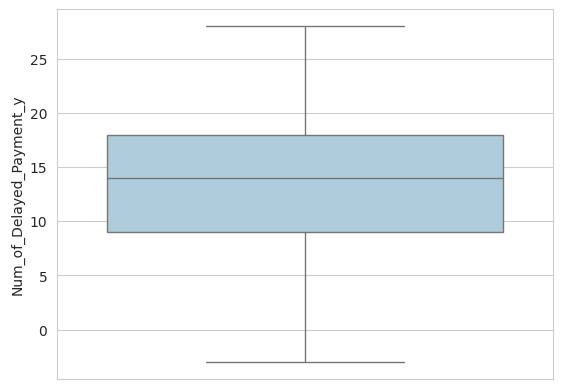

In [608]:
sns.boxplot(data_prefinal2.Num_of_Delayed_Payment_y)

In [609]:
sns.boxplot(data_prefinal2.Month_Balance_y)

<Axes: ylabel='Month_Balance_y'>

In [610]:
# Ahora limpio los de la columna Month_Balance

data_prefinal3 = limpiarTodosLosOutliers(data_prefinal2,'Month_Balance_y')

<Axes: ylabel='Month_Balance_y'>

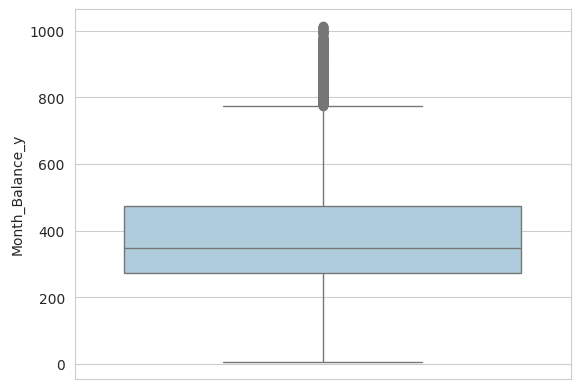

In [611]:
sns.boxplot(data_prefinal3.Month_Balance_y)

In [612]:
data_final = renombrarColumnas(data_prefinal3,'_y','')

In [613]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       6518 non-null   int64  
 1   Occupation                6518 non-null   object 
 2   Annual_Income             6518 non-null   float64
 3   Num_Bank_Accounts         6518 non-null   int64  
 4   Interest_Rate             6518 non-null   int64  
 5   Num_of_Loan               6518 non-null   int64  
 6   Delay_from_due_date       6518 non-null   int64  
 7   Changed_Credit_Limit      6518 non-null   float64
 8   Outstanding_Debt          6518 non-null   float64
 9   Credit_Utilization_Ratio  6518 non-null   float64
 10  Payment_of_Min_Amount     6518 non-null   object 
 11  Payment_Behaviour         6518 non-null   object 
 12  Credit_Score              6518 non-null   object 
 13  Num_Credit_Inquiries      6518 non-null   float64
 14  Credit_H

In [614]:
#Vuelvo a hacer un describe

data_final.describe()

Age  Annual_Income  Num_Bank_Accounts  Interest_Rate  \
count  6518.000000    6518.000000        6518.000000    6518.000000   
mean     34.437404   45597.257073           5.443388      14.781068   
std      10.127240   30686.831730           2.563558       8.728498   
min      18.000000    7006.520000           0.000000       1.000000   
25%      26.000000   20133.925000           4.000000       8.000000   
50%      34.000000   35654.545000           6.000000      14.000000   
75%      42.000000   63594.300000           7.000000      20.000000   
max      56.000000  148841.560000          11.000000      34.000000   

       Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
count  6518.000000          6518.000000           6518.000000   
mean      3.557380            21.492943             10.311273   
std       2.418791            14.934603              6.951840   
min       0.000000            -5.000000             -5.850000   
25%       2.000000            10.000000              5.120000   
50%       3.000000            18.000000              9.255000   
75%       5.000000            28.000000             15.020000   
max       9.000000            67.000000             34.850000   

       Outstanding_Debt  Credit_Utilization_Ratio  Num_Credit_Inquiries  \
count       6518.000000               6518.000000           6518.000000   
mean        1448.940618                 32.301276              6.715342   
std         1162.030025                  5.115293              3.989611   
min            0.230000                 21.447868              0.000000   
25%          580.362500                 27.964829              4.000000   
50%         1189.740000                 32.398446              6.000000   
75%         1995.560000                 36.645491             10.000000   
max         4997.100000                 44.683876             17.000000   

       Credit_History  Amount_invested_monthly  Num_of_Delayed_Payment  \
count     6518.000000              6518.000000             6518.000000   
mean        18.590900               158.583878               13.516477   
std          8.064792               114.890744                6.078298   
min          0.666667                 0.000000               -3.000000   
25%         12.500000                74.238693                9.000000   
50%         18.666667               125.082488               14.000000   
75%         24.750000               209.192109               18.000000   
max         33.666667               552.110683               28.000000   

       Month_Balance  Total_EMI_per_month  
count    6518.000000          6518.000000  
mean      398.652573           108.539391  
std       183.555749            80.775363  
min         5.958076             4.462837  
25%       274.467719            46.283930  
50%       347.361339            82.680253  
75%       474.861599           155.848274  
max      1013.505949           375.723252

In [615]:
# Ahora consulto la matriz de correlación

data_final.select_dtypes(include='number').corr()

Age  Annual_Income  Num_Bank_Accounts  \
Age                       1.000000       0.068358          -0.151366   
Annual_Income             0.068358       1.000000          -0.251677   
Num_Bank_Accounts        -0.151366      -0.251677           1.000000   
Interest_Rate            -0.174418      -0.271696           0.586361   
Num_of_Loan              -0.168488      -0.234685           0.463231   
Delay_from_due_date      -0.129539      -0.220254           0.555735   
Changed_Credit_Limit     -0.114541      -0.154737           0.319755   
Outstanding_Debt         -0.172746      -0.259712           0.507312   
Credit_Utilization_Ratio -0.005454       0.182549          -0.071664   
Num_Credit_Inquiries     -0.200218      -0.264012           0.494047   
Credit_History            0.184296       0.275859          -0.471546   
Amount_invested_monthly   0.037219       0.509155          -0.139568   
Num_of_Delayed_Payment   -0.144948      -0.234012           0.575472   
Month_Balance             0.094571       0.783113          -0.301474   
Total_EMI_per_month      -0.037847       0.587371           0.054542   

                          Interest_Rate  Num_of_Loan  Delay_from_due_date  \
Age                           -0.174418    -0.168488            -0.129539   
Annual_Income                 -0.271696    -0.234685            -0.220254   
Num_Bank_Accounts              0.586361     0.463231             0.555735   
Interest_Rate                  1.000000     0.554441             0.582209   
Num_of_Loan                    0.554441     1.000000             0.490494   
Delay_from_due_date            0.582209     0.490494             1.000000   
Changed_Credit_Limit           0.355647     0.351107             0.273007   
Outstanding_Debt               0.629333     0.641890             0.557881   
Credit_Utilization_Ratio      -0.067662    -0.077787            -0.057108   
Num_Credit_Inquiries           0.618595     0.548121             0.514108   
Credit_History                -0.572526    -0.592233            -0.471791   
Amount_invested_monthly       -0.148508    -0.129565            -0.117119   
Num_of_Delayed_Payment         0.559634     0.461297             0.525122   
Month_Balance                 -0.344158    -0.462663            -0.295456   
Total_EMI_per_month            0.070592     0.267579             0.083315   

                          Changed_Credit_Limit  Outstanding_Debt  \
Age                                  -0.114541         -0.172746   
Annual_Income                        -0.154737         -0.259712   
Num_Bank_Accounts                     0.319755          0.507312   
Interest_Rate                         0.355647          0.629333   
Num_of_Loan                           0.351107          0.641890   
Delay_from_due_date                   0.273007          0.557881   
Changed_Credit_Limit                  1.000000          0.448909   
Outstanding_Debt                      0.448909          1.000000   
Credit_Utilization_Ratio             -0.022664         -0.065541   
Num_Credit_Inquiries                  0.352924          0.589830   
Credit_History                       -0.400047         -0.629257   
Amount_invested_monthly              -0.082221         -0.130140   
Num_of_Delayed_Payment                0.301384          0.495121   
Month_Balance                        -0.204047         -0.354749   
Total_EMI_per_month                   0.046992          0.105287   

                          Credit_Utilization_Ratio  Num_Credit_Inquiries  \
Age                                      -0.005454             -0.200218   
Annual_Income                             0.182549             -0.264012   
Num_Bank_Accounts                        -0.071664              0.494047   
Interest_Rate                            -0.067662              0.618595   
Num_of_Loan                              -0.077787              0.548121   
Delay_from_due_date                      -0.057108              0.514108   
Changed_Credit_Limit    

# Visualizaciones

Por temas de tiempo de proceso no incluí un pairplot abierto por Credit Score, más allá que lo ejecuté en algún momento para tener una idea global de las distribuciones.

## Matriz de Correlación

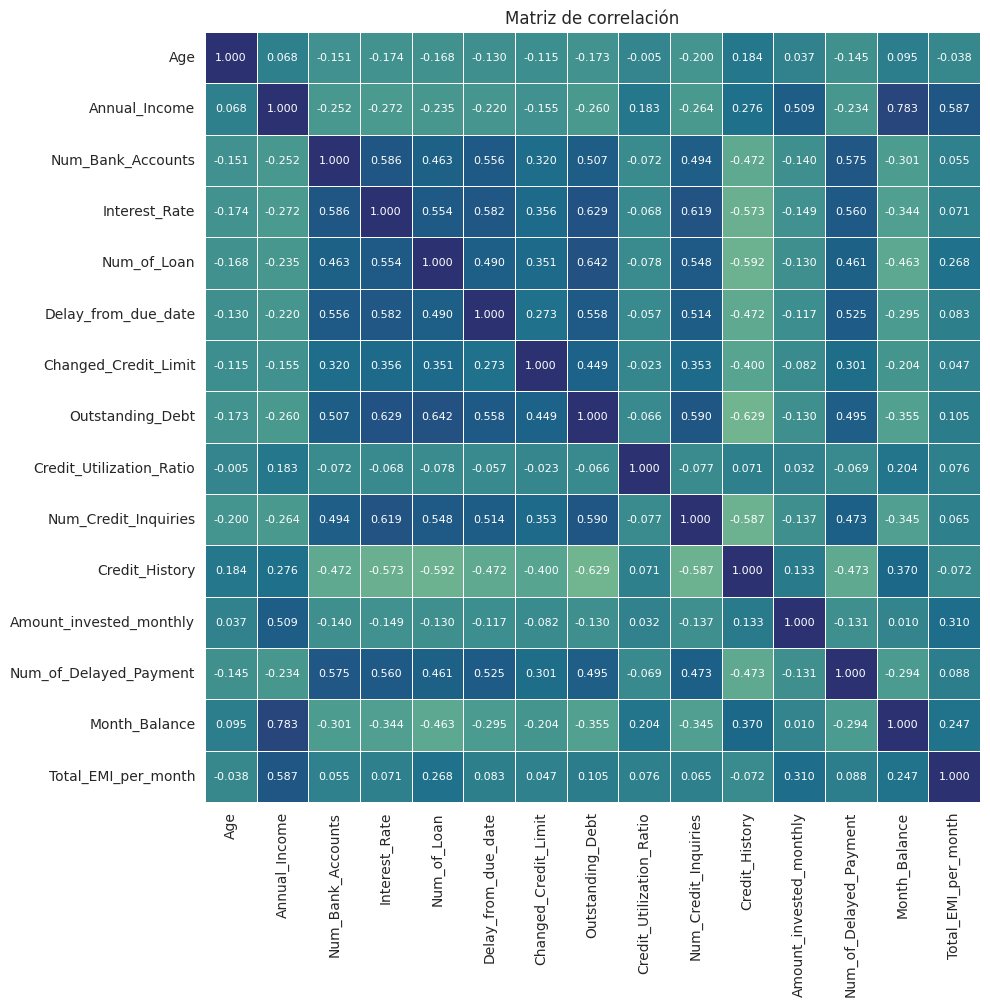

In [616]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(data_final.select_dtypes(include='number').corr(),ax=ax,linewidths=.5,fmt='.3f',cmap='crest',annot=True,vmin=-1,vmax=1,center=0,annot_kws = {"size":8},cbar=False)
ax.set_title('Matriz de correlación')
plt.show()

La matriz de correlación nos permite identificar de forma sencilla aquellas variables que presetan relación lineal, ya sea positiva o negativa. Valores cercanos a 1 implican relación positiva fuerte. En cambio, valores cercanos a -1 nos indican relación negativa fuerte. Valores cercanos a 0 implican muy baja o nula relación lineal entre vairables.
En la matriz de arriba se encuentra relación positiva media o media-fuerte desde las variables Num_Bank_Accounts hasta Outstanding_Debt. Credit History presenta una relación lineal negativa media a media-fuerte con las con el grupo de variables mencionadas anteriormente. Month_Balance también presenta una relación lineal negativa con el mismo grupo de variables, pero en este caso la relación es media a media-debil. La correlación más fuerte que tenemos en el dataset corresponde a las variables Annual_Income y Month_Balance.

## Categorías / Proporciones

In [617]:
titulos = ['Cantidad de clientes por tipo de calificación crediticia','Calificación Crediticia','Cantidad']
medidas = [8,4]
graficarCategorias(data_final.Credit_Score,titulos,medidas)

In [618]:
graficarProporciones(data_final.Credit_Score,'Calificación Crediticia',[6,4])

El dataset presenta un 52.3% de casos calificados como Standard, un 30.5% como Poor, y por último un 17.2% para la calificación Good.

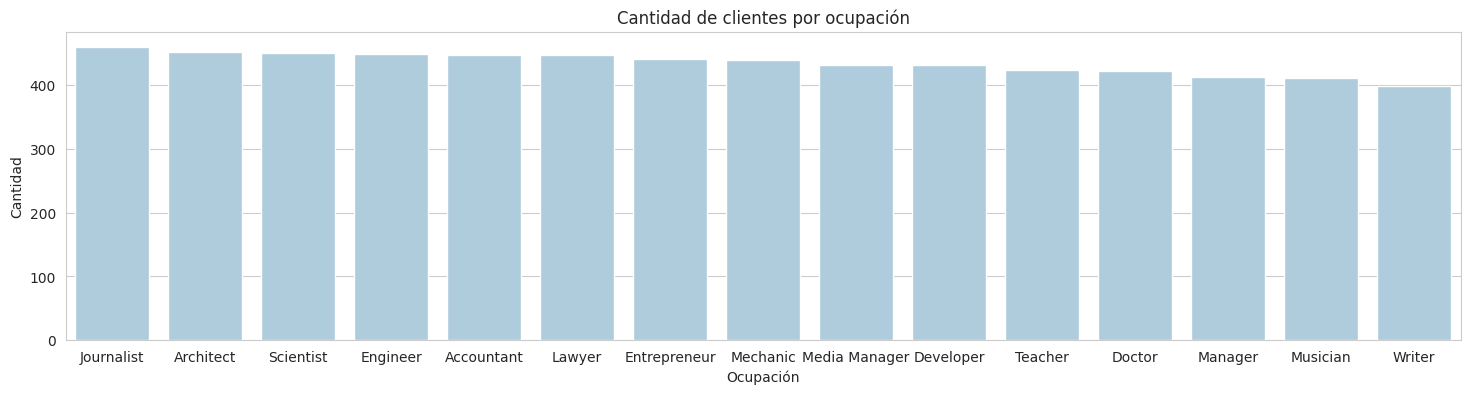

In [619]:
titulos = ['Cantidad de clientes por ocupación','Ocupación','Cantidad']
medidas = [18,4]
graficarCategorias(data_final.Occupation,titulos,medidas)

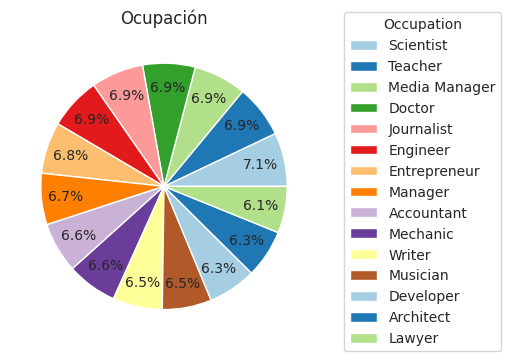

In [620]:
graficarProporciones(data_final.Occupation,'Ocupación',[7,4])

Las ocupaciones de los clientes se reparten en cantidades prácticamente iguales, en rangos que van del 6.5% al 7.1% de los casos de la muestra.

In [621]:
titulos = ['Cantidad de clientes que pagan el mínimo','Si/No','Cantidad']
medidas = [6,4]
graficarCategorias(data_final.Payment_of_Min_Amount,titulos,medidas)

In [622]:
graficarProporciones(data_final.Payment_of_Min_Amount,'Pago Mínimo',[8,4])

El 54% de los clientes no realizó pago mínimo.

In [623]:
titulos = ['Cantidad de clientes por tipo de comportamiento','Comportamiento','Cantidad']
medidas = [20,5]
graficarCategorias(data_final.Payment_Behaviour,titulos,medidas)

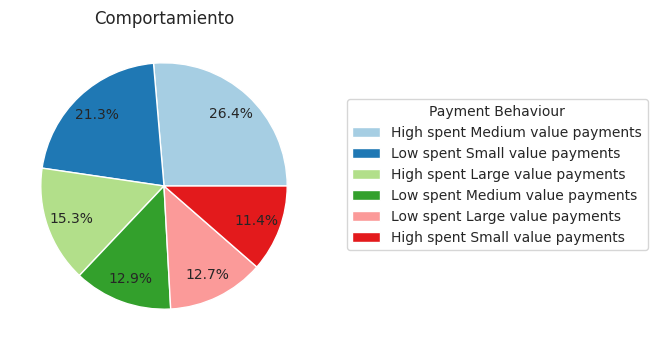

In [624]:
graficarProporciones(data_final.Payment_Behaviour,'Comportamiento',[10,4])

El Payment Behavior tiene 6 categorías de las cuales dos representan el 47.7% de los casos de la muestra. La categoría que podría representar más riesgo creditidicio, High spent - Small value payments representa el 11.4% de los casos de la muestra. La categoría que podría representar menor exposición a riesgo, Low spent - Large value payments, se encuentra en el 12.7% de los casos.

## Distribuciones

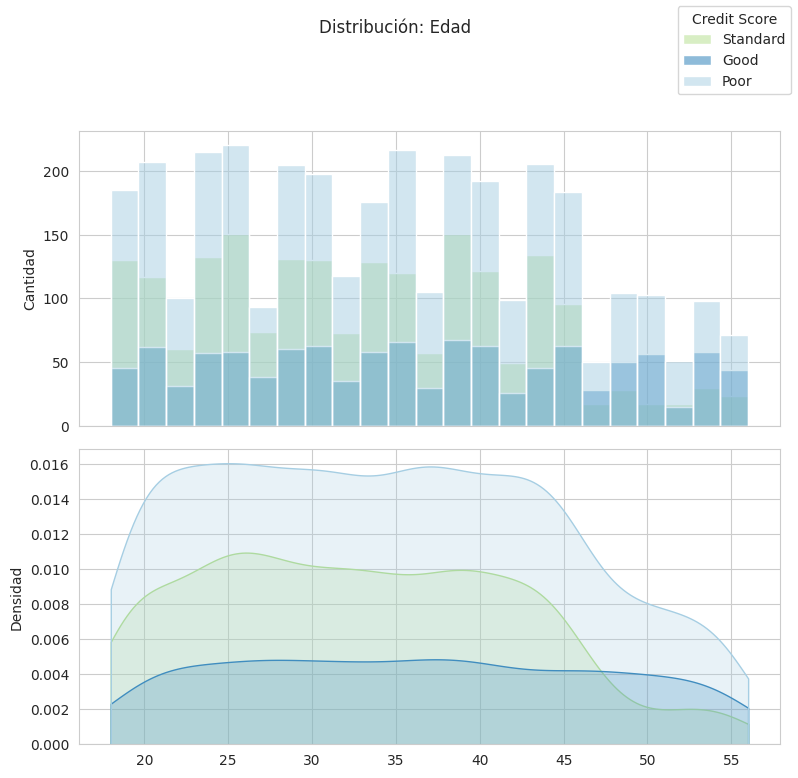

In [625]:
graficarDistribucion(data_final.Age,data_final.Credit_Score,'Distribución: Edad')

La variable Age no tiene una distribución normal. En el caso de las categorías Poor y Standard, presentan asimentría hacia la derecha. En el caso de la categoría Good la distribución es más uniforme.

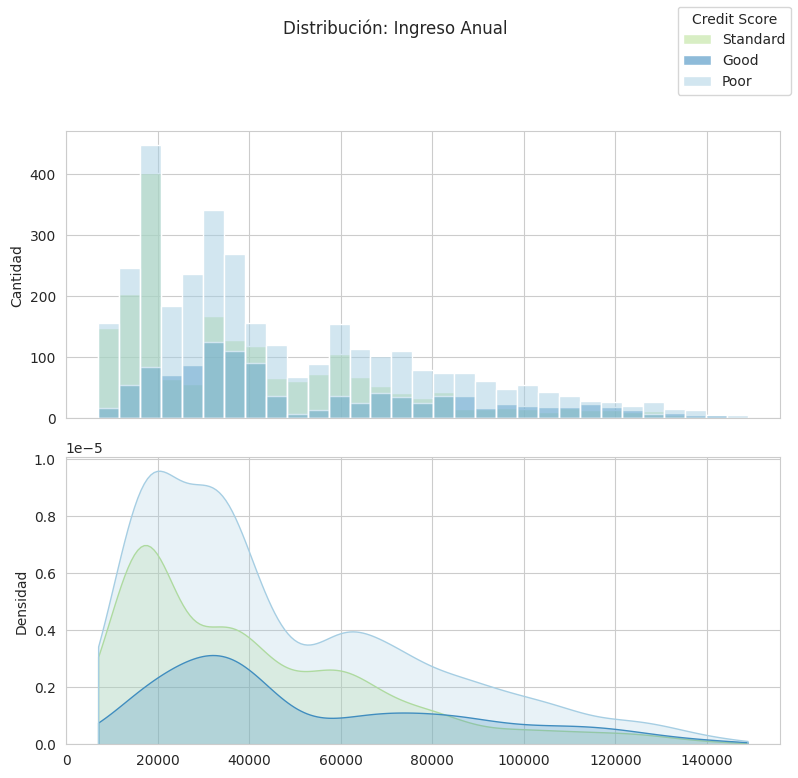

In [626]:
graficarDistribucion(data_final.Annual_Income, data_final.Credit_Score, 'Distribución: Ingreso Anual')

El Annual_Income tiene distribuciones no normales con asimetría derecha. En el caso de la categoría Good, la distribución deja en evidencia un mayor valor medio, así como una mediana mayor a las otras categorías.

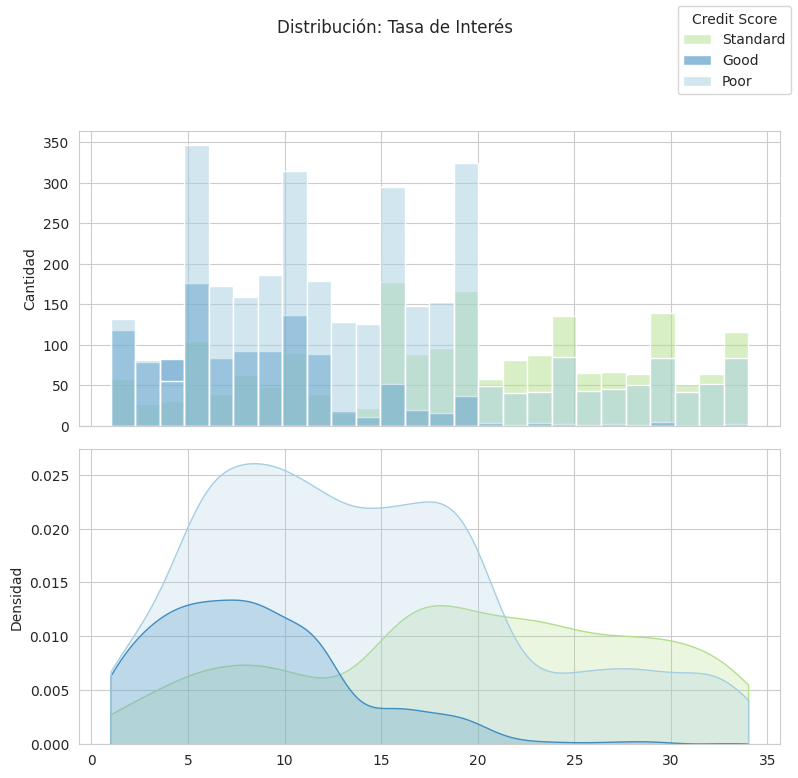

In [627]:
graficarDistribucion(data_final.Interest_Rate,data_final.Credit_Score,'Distribución: Tasa de Interés')

Interest_Rate presenta distintas asimetrías según el credit score. Para los casos de la categoría Good, los datos se distribuyen con marcada asimetría a la derecha, con gran proporción de valores concentrados por debajo del 15% de Interest_Rate. La categoría Poor presenta también asimetría hacia la derecha, con una cola alta, lo que implica una media alta. Para la categoría restante, Standard, la asimentría es leve hacia la izquierda. La distribución indicna una media mayor a la cateogoría Good, pero menor a la categoría Poor.

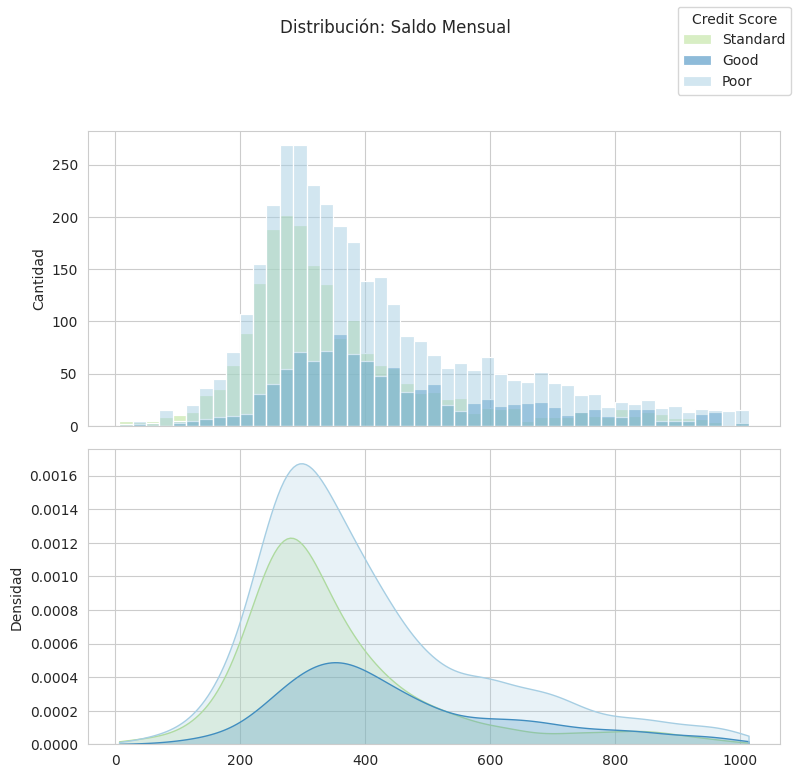

In [628]:
graficarDistribucion(data_final.Month_Balance,data_final.Credit_Score,'Distribución: Saldo Mensual')

Month_Balance presenta una distribución similar al Annual_Income, con valores medios más altos par a la categoría Good.

In [629]:
graficarDistribucion(data_final.Total_EMI_per_month,data_final.Credit_Score,'Distribución: Pago Mensual Equivalente')

En este caso se encuentran distribuciones con marcada asimetría a la derecha. En el caso de la categoría Poor se puede identificar una media más baja y una cola que se va achatando rápido. La categoría Standard presenta una media más alta con un achatamiento más leve de la cola. Por último, Good presenta un valor medio más alto por un leve achatamiento de la cola. Es más probable encontrar valores más altos en comparación con la distribución de las otras cateogrías de esta variable.

## Relacionando variables

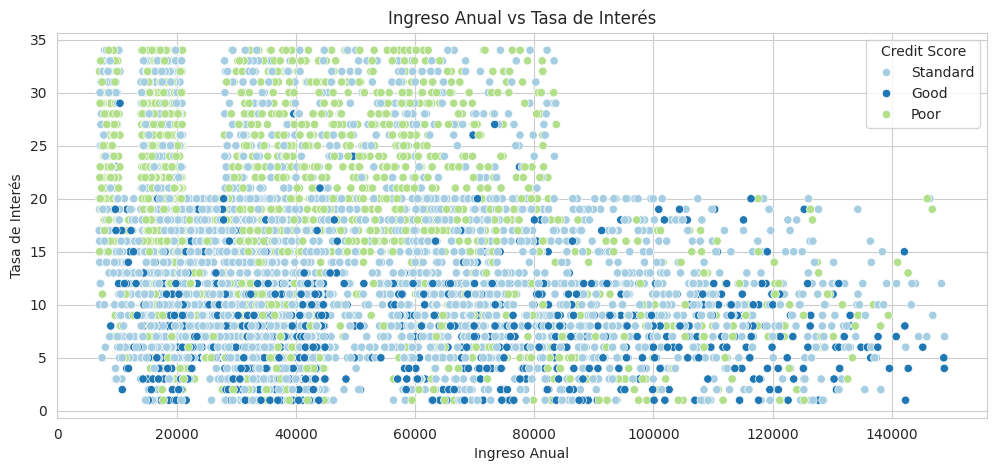

In [630]:
titulos = ['Ingreso Anual','Tasa de Interés']
graficarScatterplot(data_final.Annual_Income,data_final.Interest_Rate,data_final.Credit_Score,titulos)

La correlación entre estas variables es de -0.272, lo que implica una relación lineal negativa. Al analizarla abierta por credit score, para la categoría Poor se encuentran mayor cantidad de casos de valores altos de Interest Rate (entre 15% y 35%) para valores menores a USD 80.000 de Annual Income. Para el caso de la categoría Standard la mayor cantidad de valores de Interest Rate se encuentran debajo del 20%, y mayor concentración de Annual Income menor a USD 100.000. Para la última categoría, Interest Rate está marcada mente debajo del 15% con una distribución más uniforme del Annual Income.

In [631]:
titulos = ['Ingreso Anual','Deuda Pendiente']
graficarScatterplot(data_final.Annual_Income,data_final.Outstanding_Debt,data_final.Credit_Score,titulos)

La correlación entre esta variables nos indina una relación lineal negativa de -0.26. El análisis es similar al caso anterior.

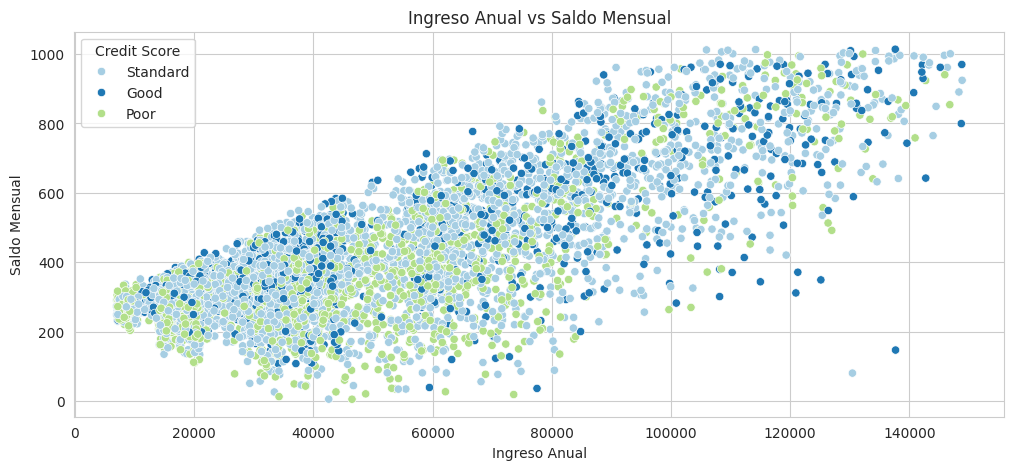

In [632]:
titulos = ['Ingreso Anual','Saldo Mensual']
graficarScatterplot(data_final.Annual_Income,data_final.Month_Balance,data_final.Credit_Score,titulos)

Entre Annual Income y Month Balance se encuentra la relación lineal positiva más fuerte del dataset, de 0.783. Se encuentra mayor concentración de valores de Month Balance y Annual Income para la categoría Poor de credit score.

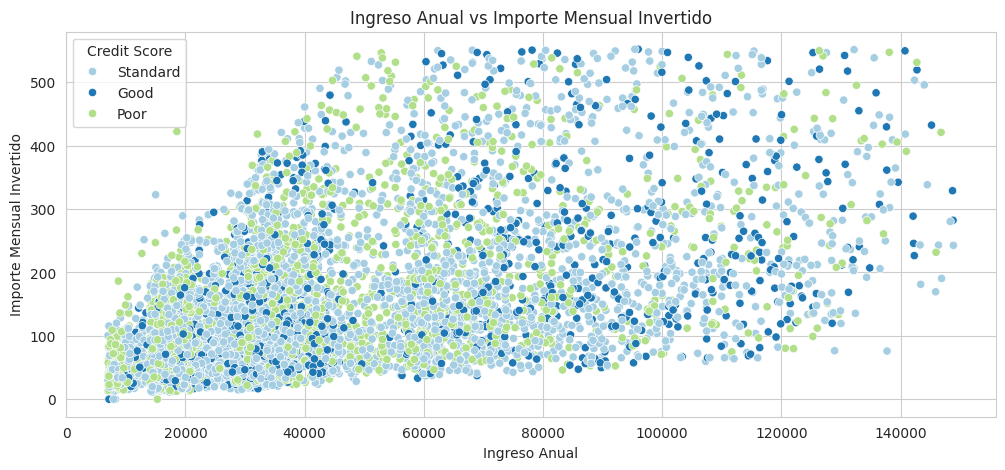

In [633]:
titulos = ['Ingreso Anual','Importe Mensual Invertido']
graficarScatterplot(data_final.Annual_Income,data_final.Amount_invested_monthly,data_final.Credit_Score,titulos)

La correlación entre Annual Income y Amount Invested Monthly es posiva del 0.509, lo que implica una relación media. Menores valores de Annual Income y Amount Invested Monthly se encuentran para la categoría Poor de credit score.

In [634]:
titulos = ['Ingreso Anual','Cuota Mensual Equivalente']
graficarScatterplot(data_final.Annual_Income,data_final.Total_EMI_per_month,data_final.Credit_Score,titulos)

La correlación entre Annual Income y Total EMI per month es positiva de 0.587, y presenta un gráfico similar al anterior, por lo que su análisis es similar.

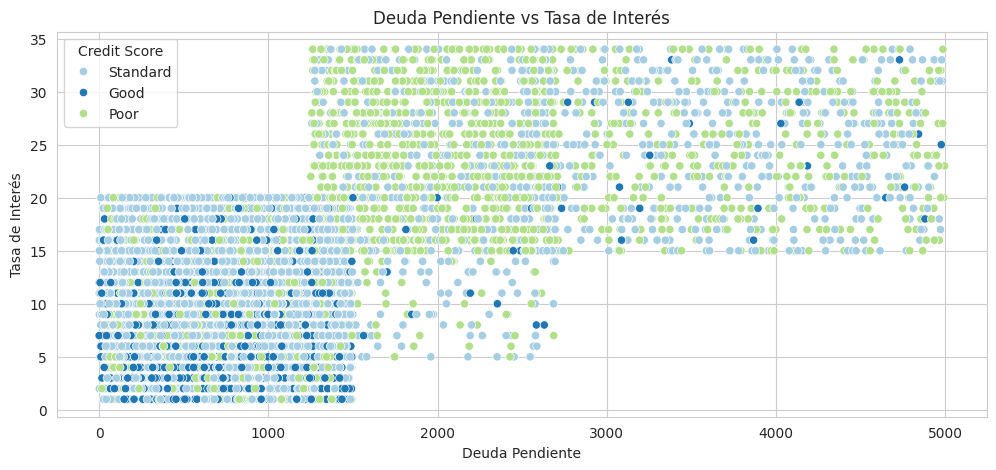

In [635]:
titulos = ['Deuda Pendiente','Tasa de Interés']
graficarScatterplot(data_final.Outstanding_Debt,data_final.Interest_Rate,data_final.Credit_Score,titulos)

Outstanding Debt e Interest Rate tienen una relación lineal positiva de 0.629. En el gráfico se pueden identificar dos bloques principales. En el primer bloque se encuentran mayormente clientes con calificación Good o Standard, y valores bajos de Outstading Debt. En el otro bloque principal valores mayores de Outstandin Debt con Interest Rates más elevados, comprendiendo la mayor partes de los valores a calificaciones Poor, principalmente, y Standard.

In [636]:
titulos = ['Deuda Pendiente','Saldo Mensual']
graficarScatterplot(data_final.Outstanding_Debt,data_final.Month_Balance,data_final.Credit_Score,titulos)

La correlación entre Outstanding Debt y Month Balance es negativa de -0.355, lo que implica una relación media-debil. Como en el caso anterior se encuentran dos bloques bien definidos. Un primer bloque para valores bajos de Outstanding Debt y amplios valores para Month Balance, donde la mayor cantidad de casos corresponden a categorías Good y Standard de credit score. En este bloque pareciera haber una relación lineal muy baja. El segundo bloque presenta valores más altos de Outstanding Debt y valores bajos de Month Balance, con una leve tendencia negativa en la dispersión de los valores. El credit score más común en este bloque corresponde a la calificación Poor.

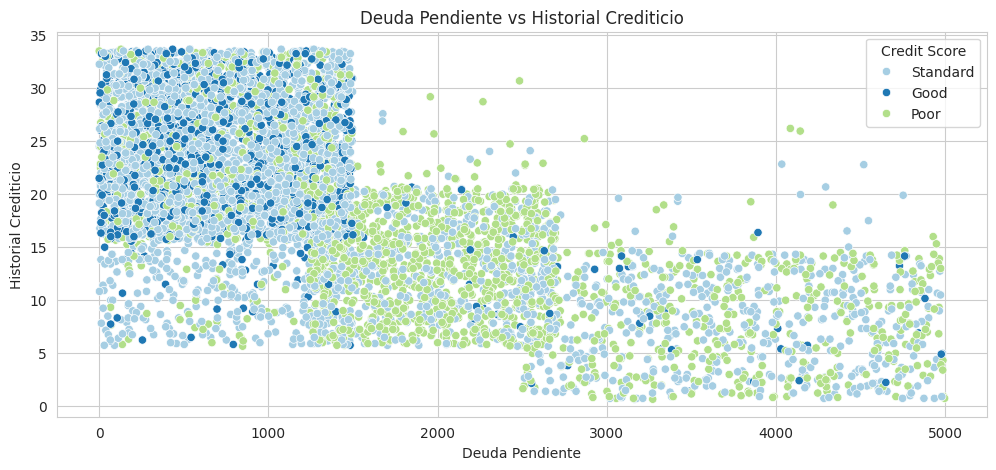

In [637]:
titulos = ['Deuda Pendiente','Historial Crediticio']
graficarScatterplot(data_final.Outstanding_Debt,data_final.Credit_History,data_final.Credit_Score,titulos)

En el caso de las variables Outstanding Debt y Credit History la correlación presenta un valor de -0.629, lo que implica una fuerte relación lineal negativa. Esto significa que a mayor deuda pendiente menor es la antigüedad del historial crediticio del cliente. El gráfico presenta tres bloques claros, en el primero se encuentran las combinaciones de Outstanding Debt baja y Credit History altos. En este bloque abundan los clientes con calificación Good y Standard. En el segundo bloque y en el tercer bloque se encuentran combinaciones de valores con predominacia correspondientes a la calificación Poor y Standard.

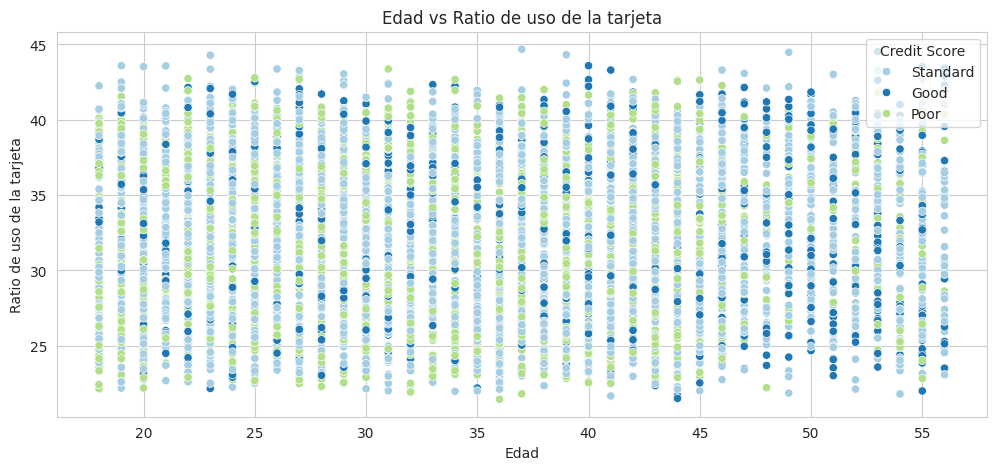

In [638]:
titulos = ['Edad','Ratio de uso de la tarjeta']
graficarScatterplot(data_final.Age,data_final.Credit_Utilization_Ratio,data_final.Credit_Score,titulos)

Entre Age y Credit_Utilization_Ratio la correlación es de -0.005, lo que implica que la relación lineal entre ambas es prácticamente nula. Al ver el gráfico no se logra distinguir ningún patrón ni tendencia clara. Solamente al tener los datos abiertos por credit score se logra indentificar que los clientes menores a 45 años presentan más casos de calificación Poor, y los mayores a 45, calificaciones Standard y Good.

# Modelado

### Importación de librerías

In [639]:
import sklearn.feature_selection as fs
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

## Configuración del pipeline

In [640]:
# Split

df_X = data_final.drop(columns='Credit_Score')
df_y = data_final.Credit_Score
(X_train, X_test, Y_train, Y_test) = train_test_split(df_X,df_y,test_size = 0.2,random_state=10)

In [641]:
# Clasificación de columnas en numéricas y categróricas para configuración posterior del transformador

columnasNumericas = X_train.select_dtypes(include=['number']).columns.to_list()
columnasCategoricas = X_train.select_dtypes(include=['object']).columns.to_list()

In [642]:
# Instanciación del transformador con el Standard Scaler para las columnas numéricas y One Hot Encoder para las categóricas

preProcesador = ColumnTransformer(
    [('scale',StandardScaler(), columnasNumericas),
     ('onehot',OneHotEncoder(drop='first',sparse_output=False), columnasCategoricas)],
    verbose_feature_names_out = False
    ).set_output(transform="pandas")

In [643]:
preProcesador

ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 ['Age', 'Annual_Income', 'Num_Bank_Accounts',
                                  'Interest_Rate', 'Num_of_Loan',
                                  'Delay_from_due_date', 'Changed_Credit_Limit',
                                  'Outstanding_Debt',
                                  'Credit_Utilization_Ratio',
                                  'Num_Credit_Inquiries', 'Credit_History',
                                  'Amount_invested_monthly',
                                  'Num_of_Delayed_Payment', 'Month_Balance',
                                  'Total_EMI_per_month']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Occupation', 'Payment_of_Min_Amount',
                                  'Payment_Behaviour'])],
                  verbose_feature_names_out=False)

In [644]:
# Instanciación del pipeline

pipe = Pipeline([('preprocesor', preProcesador),('estimator', KNeighborsClassifier())])

## Evaluando modelos

Para evitar problemas de rendimiento al hacer el fit del grid search decidí separar el proceso en dos pasos:
1. Elegir el mejor modelo con sus parámetros base.
2. Hacer el hypertunning sobre el mejor modelo

Cuando hice la prueba de hacer todo en un solo paso la performance del Colab fue mala, demorando demasiado tiempo.

In [645]:
parametros = [
    {
        'estimator': [KNeighborsClassifier()]
    },
    {
        'estimator': [DecisionTreeClassifier()],
    },
    {
        'estimator': [RandomForestClassifier()],
        'estimator__random_state': [10]
    },
    {
        'estimator': [GradientBoostingClassifier()],
        'estimator__random_state': [10]
    }
]

In [646]:
gridSearch = GridSearchCV(estimator = pipe, param_grid = parametros, cv = 5)

In [647]:
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Interest_Rate',
                                                                          'Num_of_Loan',
                                                                          'Delay_from_due_date',
                                                                          'Changed_Credit_Limit',
                                                                          'Outstanding_Debt',
                                                                          'Credit_Utilization_Ratio',
                                                                          'Num_Credit_Inquiries',
                                                                          'Credit_History',
                                                                          'Amount_invested_monthly',
                                                                          'Nu...
                                                                          'Payment_of_Min_Amount',
                                                                          'Payment_Behaviour'])],
                                                          verbose_feature_names_out=False)),
                                       ('estimator', KNeighborsClassifier())]),
             param_grid=[{'estimator': [KNeighborsClassifier()]},
                         {'estimator': [DecisionTreeClassifier()]},
                         {'estimator': [RandomForestClassifier()],
                          'estimator__random_state': [10]},
                         {'estimator': [GradientBoostingClassifier()],
                          'estimator__random_state': [10]}])

In [648]:
cv_resultados = pd.DataFrame(gridSearch.cv_results_).sort_values('rank_test_score')
cv_resultados

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       1.277128      0.006073         0.040848        0.004672   
3       6.944610      0.470593         0.017646        0.000536   
0       0.030201      0.004360         0.117782        0.017927   
1       0.120560      0.003139         0.011439        0.000275   

                param_estimator  param_estimator__random_state  \
2      RandomForestClassifier()                           10.0   
3  GradientBoostingClassifier()                           10.0   
0        KNeighborsClassifier()                            NaN   
1      DecisionTreeClassifier()                            NaN   

                                              params  split0_test_score  \
2  {'estimator': RandomForestClassifier(), 'estim...           0.613615   
3  {'estimator': GradientBoostingClassifier(), 'e...           0.616491   
0              {'estimator': KNeighborsClassifier()}           0.547459   
1            {'estimator': DecisionTreeClassifier()}           0.502397   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2           0.610738           0.615532           0.597315           0.574856   
3           0.592522           0.604986           0.592522           0.580614   
0           0.555129           0.543624           0.536913           0.555662   
1           0.505273           0.492809           0.492809           0.480806   

   mean_test_score  std_test_score  rank_test_score  
2         0.602411        0.015181                1  
3         0.597427        0.012259                2  
0         0.547758        0.007094                3  
1         0.494819        0.008616                4

El mejor modelo fue el Random Forest Classifier, en el próximo paso le realizo el hypertunning correspondiente para poder evaluar el desemeño final del modelo.

## Hypertunning

In [649]:
pipeFinal = Pipeline([('preprocesor', preProcesador),('estimator', gridSearch.best_estimator_.named_steps['estimator'])])

In [650]:
parametrosFinal = [
    {
        'estimator__max_features': ['sqrt','log2'],
        'estimator__n_estimators': [ 100, 200, 300],
        'estimator__max_depth': [ 3, 5, 7],
        'estimator__random_state': [10]
    }
]

In [651]:
gridSearchFinal = GridSearchCV(estimator = pipeFinal, param_grid = parametrosFinal, cv = 5)

In [652]:
gridSearchFinal.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Interest_Rate',
                                                                          'Num_of_Loan',
                                                                          'Delay_from_due_date',
                                                                          'Changed_Credit_Limit',
                                                                          'Outstanding_Debt',
                                                                          'Credit_Utilization_Ratio',
                                                                          'Num_Credit_Inquiries',
                                                                          'Credit_History',
                                                                          'Amount_invested_monthly',
                                                                          'Nu...
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['Occupation',
                                                                          'Payment_of_Min_Amount',
                                                                          'Payment_Behaviour'])],
                                                          verbose_feature_names_out=False)),
                                       ('estimator',
                                        RandomForestClassifier(random_state=10))]),
             param_grid=[{'estimator__max_depth': [3, 5, 7],
                          'estimator__max_features': ['sqrt', 'log2'],
                          'estimator__n_estimators': [100, 200, 300],
                          'estimator__random_state': [10]}])

## Entrenamiento y clasificación

In [653]:
modeloFinal = gridSearchFinal.best_estimator_

In [654]:
modeloFinal.fit(X_train, Y_train)

Pipeline(steps=[('preprocesor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Num_Bank_Accounts',
                                                   'Interest_Rate',
                                                   'Num_of_Loan',
                                                   'Delay_from_due_date',
                                                   'Changed_Credit_Limit',
                                                   'Outstanding_Debt',
                                                   'Credit_Utilization_Ratio',
                                                   'Num_Credit_Inquiries',
                                                   'Credit_History',
                                                   'Amount_invested_monthly',
                                                   'Num_of_Delayed_Payment',
                                                   'Month_Balance',
                                                   'Total_EMI_per_month']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Occupation',
                                                   'Payment_of_Min_Amount',
                                                   'Payment_Behaviour'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 RandomForestClassifier(max_depth=7, random_state=10))])

In [655]:
y_pred = modeloFinal.predict(X_test)

## Classification Report

In [656]:
from sklearn.metrics import classification_report

In [657]:
print(classification_report(y_pred, Y_test))

              precision    recall  f1-score   support

        Good       0.05      0.69      0.10        16
        Poor       0.55      0.66      0.60       329
    Standard       0.83      0.60      0.70       959

    accuracy                           0.62      1304
   macro avg       0.48      0.65      0.47      1304
weighted avg       0.75      0.62      0.67      1304



El modelo tiene un accuracy del 62%, lo cual es aceptable.
Presenta un problema serio para clasificar adecuadamente la clase 'Good', con una precisión del 5%.
El modelo clasifica bien el 65%& de las clases reales, pero tiene un F1-score bajo.

## Matriz de Confusión

In [658]:
categorias = ['Good','Standard','Poor']
cm = confusion_matrix(Y_test, y_pred, labels=categorias)
pd_cm = pd.DataFrame(cm, index=categorias, columns=categorias)

<Axes: >

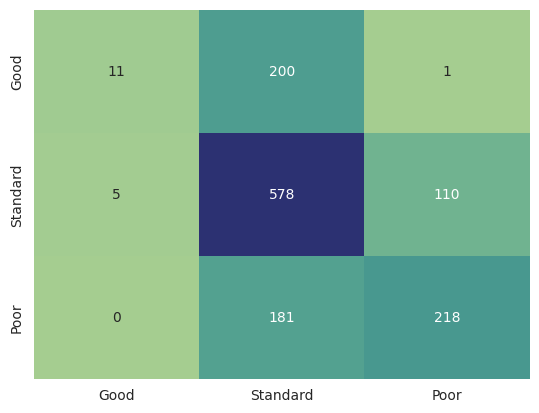

In [659]:
sns.heatmap(pd_cm, annot=True,fmt='d',cmap='crest',cbar=False)

La matriz de confusión muestra claramente la mala performace de la clase 'Good'. Lo único positivo es que las clasifica con 'Standard', lo que deja la puerta abierta a una solución alternativa al problema planteado (ver anexo).

# Explicabilidad

## Importación de librerías

In [660]:
!pip install shap

In [661]:
import shap

## Transformación y cálculo de shap values

In [662]:
X_test_transformed = modeloFinal[:-1].transform(X_test)

In [663]:
explainer = shap.TreeExplainer(modeloFinal.named_steps['estimator'])

In [664]:
shap_values = explainer(X_test_transformed)

## Resumen

En el documento se encuentran las explicaciones correspondientes.

### Clase *Good*

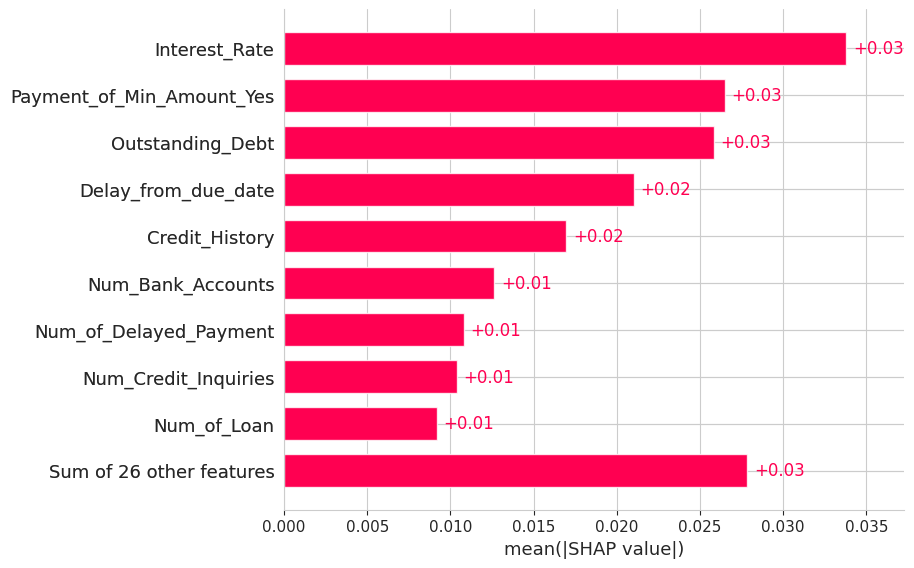

In [665]:
shap_values_single_class = shap_values[..., 0]
shap.plots.bar(shap.Explanation(
    values=shap_values_single_class,
    base_values=shap_values.base_values[..., 0],
    feature_names = X_test_transformed.columns,
    data=X_test_transformed
))

In [666]:
shap.summary_plot(shap_values[..., 0], X_test_transformed, feature_names=X_test_transformed.columns)

### Clase *Standard*

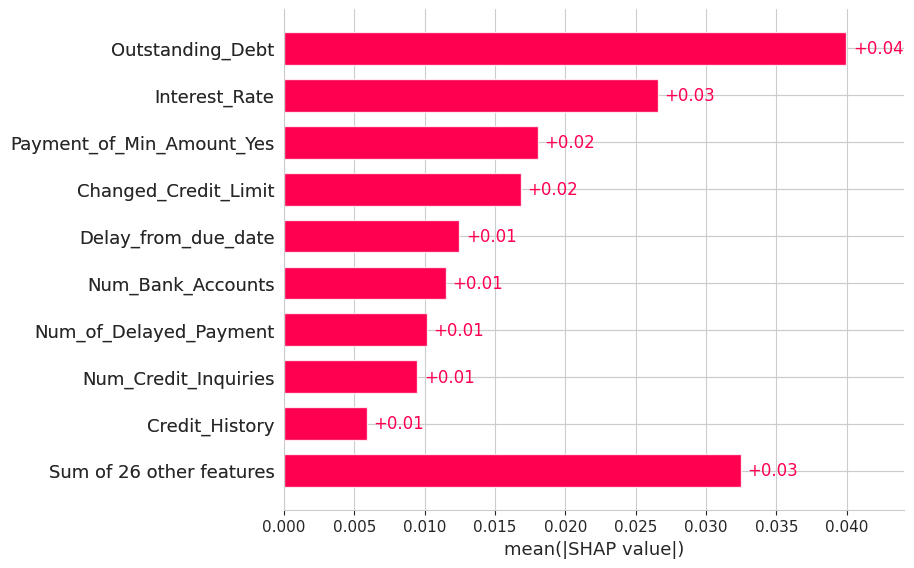

In [667]:
shap_values_single_class = shap_values[..., 2]
shap.plots.bar(shap.Explanation(
    values=shap_values_single_class,
    base_values=shap_values.base_values[..., 2],
    feature_names = X_test_transformed.columns,
    data=X_test_transformed
))

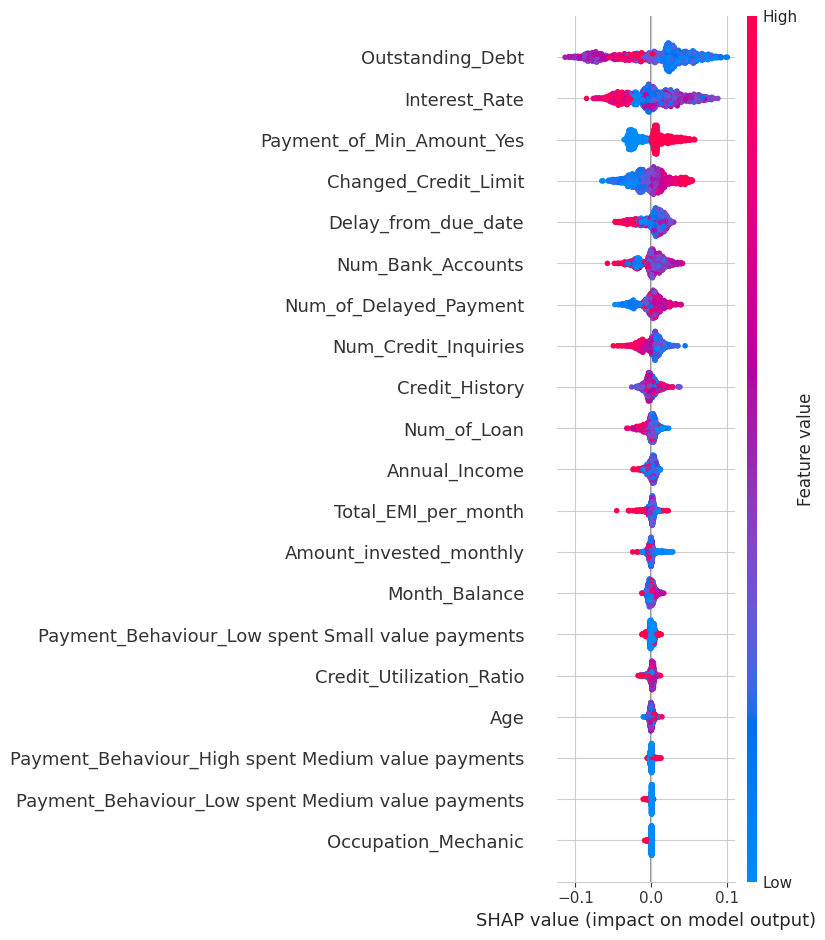

In [668]:
shap.summary_plot(shap_values[..., 2], X_test_transformed, feature_names=X_test_transformed.columns)

### Clase *Poor*

In [669]:
shap_values_single_class = shap_values[..., 1]
shap.plots.bar(shap.Explanation(
    values=shap_values_single_class,
    base_values=shap_values.base_values[..., 1],
    feature_names = X_test_transformed.columns,
    data=X_test_transformed
))

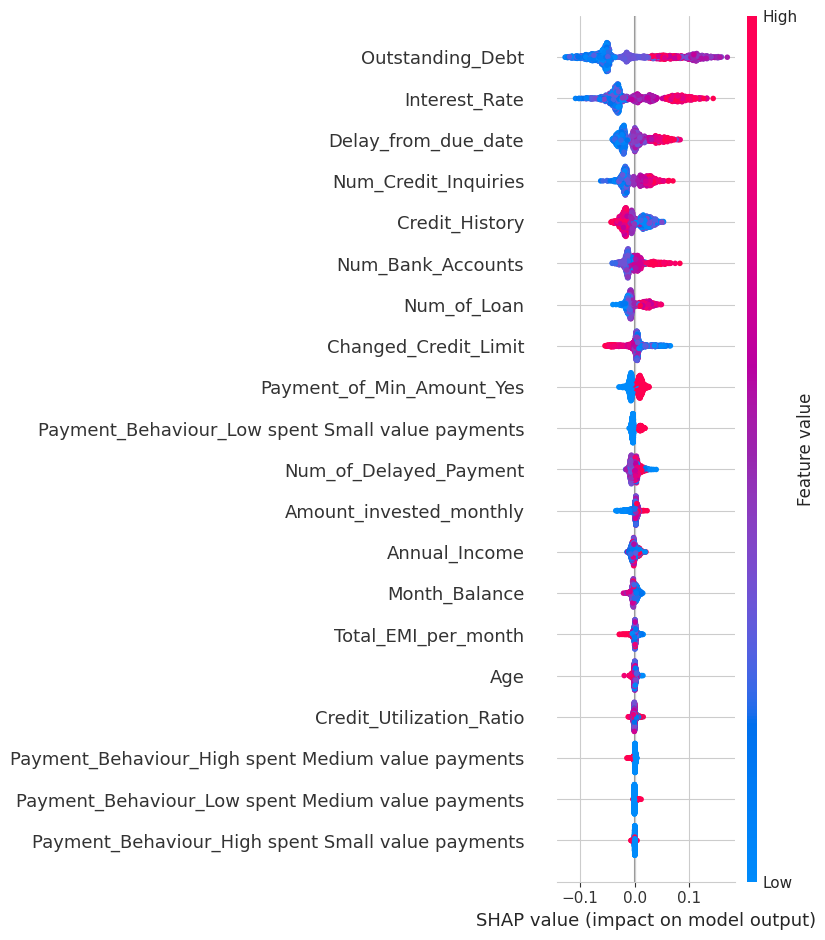

In [670]:
shap.summary_plot(shap_values[..., 1], X_test_transformed, feature_names=X_test_transformed.columns)


# Anexo: Una solución alternativa

En este apartado se elabora brevemente una solución alternativa para los problemas del modelo desarrollado en los apartados anteriores. Ya que la categoría 'Good' la clasificaba como 'Standard', voy a probar trabajar sólo con dos categorías. Para ella, los datos clasificados como 'Good' los voy a relasificar como 'Standard' para probar si se puede desarrollar un modelo superador.

In [671]:
## Importación de la librería

import xgboost as xgb

In [672]:
# Preparación del set de datos

df_y_xgb = df_y.copy()
df_y_xgb = df_y_xgb.apply(lambda x: 'Standard' if x == 'Good' else x )
df_y_xgb = df_y_xgb.apply(lambda x: 0 if x == 'Standard' else 1 )

In [673]:
# Split de datos

(X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb) = train_test_split(df_X,df_y_xgb,test_size = 0.2,random_state=10)

In [674]:
# Separación de columnas por tipo para el pre-procesador del pipeline

columnasNumericasXgb = X_train_xgb.select_dtypes(include=['number']).columns.to_list()
columnasCategoricasXgb = X_train_xgb.select_dtypes(include=['object']).columns.to_list()

In [675]:
# Instanciación del preprocesador

preProcesadorXgb = ColumnTransformer(
    [('scale',StandardScaler(), columnasNumericasXgb),
     ('onehot',OneHotEncoder(drop='first',sparse_output=False), columnasCategoricasXgb)],
    verbose_feature_names_out = False
    ).set_output(transform="pandas")

In [676]:
# Instanciación del pipeline con el pre-procesaror y el modelo

pipeXgb = Pipeline([('preprocesor', preProcesador),('estimator', xgb.XGBClassifier())])

In [677]:
# Definición de parámetros para el hypertunning

parametrosXgb = [
    {
        'estimator': [xgb.XGBClassifier()],
        'estimator__n_estimators': [ 100, 200, 300],
        'estimator__max_depth': [ 3, 5, 7],
        'estimator__random_state': [10]
    }
]

In [678]:
# Instanciación del grid search

gridSearchXgb = GridSearchCV(estimator = pipeXgb, param_grid = parametrosXgb, cv = 5)

In [679]:
# Fitting

gridSearchXgb.fit(X_train_xgb,Y_train_xgb)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Interest_Rate',
                                                                          'Num_of_Loan',
                                                                          'Delay_from_due_date',
                                                                          'Changed_Credit_Limit',
                                                                          'Outstanding_Debt',
                                                                          'Credit_Utilization_Ratio',
                                                                          'Num_Credit_Inquiries',
                                                                          'Credit_History',
                                                                          'Amount_invested_monthly',
                                                                          'Nu...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)],
                          'estimator__max_depth': [3, 5, 7],
                          'estimator__n_estimators': [100, 200, 300],
                          'estimator__random_state': [10]}])

In [680]:
cv_resultados2 = pd.DataFrame(gridSearchXgb.cv_results_).sort_values('rank_test_score')
cv_resultados2

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.665104      0.562780         0.034183        0.018998   
1       0.261304      0.014949         0.024211        0.001228   
2       0.363782      0.017338         0.024807        0.000609   
6       0.958792      1.146893         0.024943        0.000881   
4       1.796092      2.412614         0.035902        0.013930   
7       0.636994      0.010510         0.029344        0.001660   
3       0.248879      0.011187         0.024063        0.000646   
8       0.853195      0.010924         0.032854        0.004773   
5       4.470608      1.523907         0.075172        0.008544   

                                     param_estimator  \
0  XGBClassifier(base_score=None, booster=None, c...   
1  XGBClassifier(base_score=None, booster=None, c...   
2  XGBClassifier(base_score=None, booster=None, c...   
6  XGBClassifier(base_score=None, booster=None, c...   
4  XGBClassifier(base_score=None, booster=None, c...   
7  XGBClassifier(base_score=None, booster=None, c...   
3  XGBClassifier(base_score=None, booster=None, c...   
8  XGBClassifier(base_score=None, booster=None, c...   
5  XGBClassifier(base_score=None, booster=None, c...   

   param_estimator__max_depth  param_estimator__n_estimators  \
0                           3                            100   
1                           3                            200   
2                           3                            300   
6                           7                            100   
4                           5                            200   
7                           7                            200   
3                           5                            100   
8                           7                            300   
5                           5                            300   

   param_estimator__random_state  \
0                             10   
1                             10   
2                             10   
6                             10   
4                             10   
7                             10   
3                             10   
8                             10   
5                             10   

                                              params  split0_test_score  \
0  {'estimator': XGBClassifier(base_score=None, b...           0.774688   
1  {'estimator': XGBClassifier(base_score=None, b...           0.766059   
2  {'estimator': XGBClassifier(base_score=None, b...           0.753595   
6  {'estimator': XGBClassifier(base_score=None, b...           0.761266   
4  {'estimator': XGBClassifier(base_score=None, b...           0.759348   
7  {'estimator': XGBClassifier(base_score=None, b...           0.765101   
3  {'estimator': XGBClassifier(base_score=None, b...           0.755513   
8  {'estimator': XGBClassifier(base_score=None, b...           0.762224   
5  {'estimator': XGBClassifier(base_score=None, b...           0.752637   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.760307           0.777565           0.764142           0.750480   
1           0.757430           0.769895           0.759348           0.743762   
2           0.749760           0.773730           0.758389           0.738004   
6           0.735379           0.762224           0.760307           0.749520   
4           0.738255           0.760307           0.764142           0.744722   
7           0.736337           0.764142           0.758389           0.741843   
3           0.750719           0.756472           0.767977           0.734165   
8           0.735379           0.767018           0.758389           0.739923   
5           0.734420           0.762224           0.748802           0.745681   

   mean_test_score  std_test_score  rank_test_score  
0         0.765436        0.009843                1  
1         0.759299        0.008976                2  
2         0.754696        0.011663           

In [681]:
# Clasificación con el modelo

y_pred_xgb = gridSearchXgb.best_estimator_.predict(X_test_xgb)

In [682]:
# Classification Report

print(classification_report(y_pred_xgb, Y_test_xgb))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       989
           1       0.53      0.68      0.60       315

    accuracy                           0.78      1304
   macro avg       0.71      0.74      0.72      1304
weighted avg       0.80      0.78      0.79      1304



In [683]:
# Matriz de confusión

categoriasXgb = ['Standard','Poor']
cmXgb = confusion_matrix(Y_test_xgb, y_pred_xgb)
pd_cmXgb = pd.DataFrame(cmXgb, index=categoriasXgb, columns=categoriasXgb)

<Axes: >

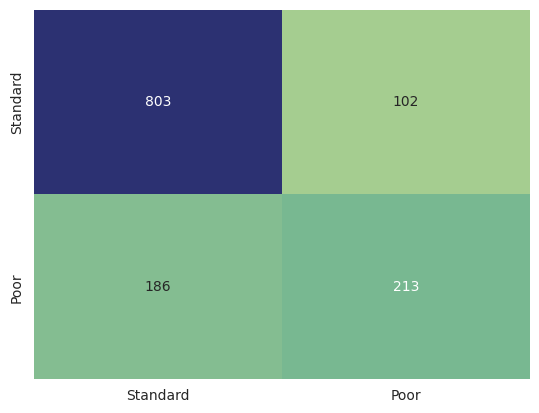

In [684]:
sns.heatmap(pd_cmXgb, annot=True,fmt='d',cmap='crest',cbar=False)

El nuevo modelo tiene un accuracy general del 78%, y valores elevados para precisión, recall y F1-score para la clase 0 ('Standard'). Para la case 1 ('Poor') los valores son aceptables, pero habría que seguir probando otros hiperparámetros en búsqueda de un modelo mejor.
Igualmente, esta propuesta alternativa presenta un desempeño superior al modelo propuesto en el cuerpo del trabajo.